<a href="https://colab.research.google.com/github/singularity-htmagarh/202404_Project_01/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the libraries

import math
# import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# New Section

In [ ]:
%pip install yfinance

     ---------------------------------------- 3.0/3.0 MB 17.3 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for peewee: filename=peewee-3.17.6-py3-none-any.whl size=138939 sha256=7c2ad1130ac908c121cd0f36b90076a41fe8dd68fc16259923a6ea7108934cc8
  Stored in directory: c:\users\d\appdata\local\pip\cache\wheels\4b\b9\b0\83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

#Get the Index price
sp500=yf.Ticker("^GSPC")
sp500=sp500.history(period="max")

In [3]:
#Show the data
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-10-17 00:00:00-04:00,5875.620117,5878.459961,5840.250000,5841.470215,3480010000,0.0,0.0
2024-10-18 00:00:00-04:00,5859.430176,5872.169922,5846.109863,5864.669922,3374490000,0.0,0.0
2024-10-21 00:00:00-04:00,5857.819824,5866.919922,5824.790039,5853.979980,3407010000,0.0,0.0


<Axes: xlabel='Date'>

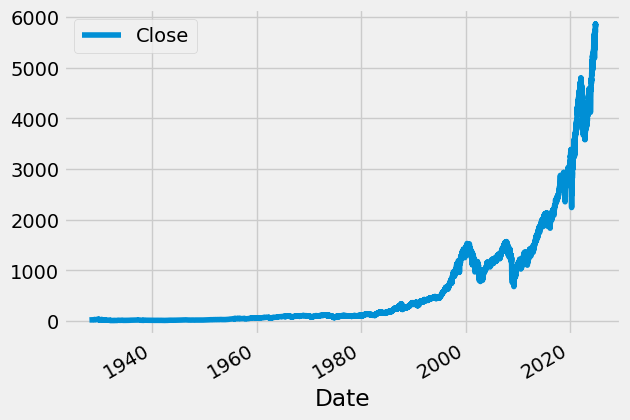

In [4]:
sp500.plot.line(y='Close',use_index=True)

In [9]:
sp500 = sp500.loc['1990-01-01':].copy()

# del sp500['Dividends']
# del sp500['Stock Splits']

sp500['Tomorrow']=sp500['Close'].shift(-1)
sp500['Target']=(sp500['Tomorrow']>sp500['Close']).astype(int)


<Axes: xlabel='Date'>

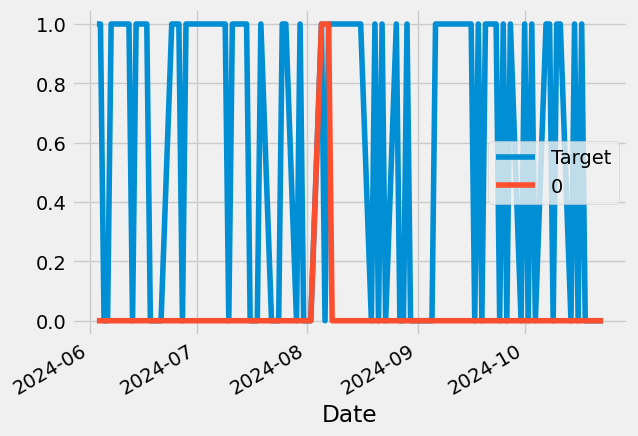

In [10]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100,min_samples_split=100,random_state=1)

train=sp500.iloc[:-100]
test=sp500.iloc[-100:]

predictors = ['Close','Volume','Open','High','Low']
model.fit(train[predictors],train['Target'])

from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test['Target'],preds)

combined = pd.concat([test["Target"],preds],axis=1)
combined.plot()

In [15]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds=model.predict(test[predictors])
    preds=pd.Series(preds, index=test.index, name="Predictions")
    combined =pd.concat([test['Target'],preds],axis=1)
    return combined

def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0],step):
        train=data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [16]:
predictions = backtest(sp500, model, predictors)
predictions['Predictions'].value_counts()

precision_score(predictions['Target'], predictions['Predictions'])
predictions['Target'].value_counts() / predictions.shape[0]

,count
Target,
1,0.535566
0,0.464434


In [17]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"]/rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [18]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

predictions = backtest(sp500, model, new_predictors)
predictions['Predictions'].value_counts()
precision_score(predictions['Target'],predictions['Predictions'])

predictions['Target'].value_counts()/predictions.shape[0]
predictions

,Target,Predictions
Date,,
2003-11-14 00:00:00-05:00,0,0.0
2003-11-17 00:00:00-05:00,0,1.0
2003-11-18 00:00:00-05:00,1,1.0
2003-11-19 00:00:00-05:00,0,0.0
2003-11-20 00:00:00-05:00,1,1.0
...,...,...
2024-10-17 00:00:00-04:00,1,0.0
2024-10-18 00:00:00-04:00,0,0.0
2024-10-21 00:00:00-04:00,0,0.0


In [21]:
# prompt: Using dataframe predictions: create a contingency table for the target vs prediction

# Create a contingency table (cross-tabulation) of Target vs Predictions
contingency_table = pd.crosstab(predictions['Target'], predictions['Predictions'])

# Display the contingency table
contingency_table

Predictions,0.0,1.0
Target,,
0,2036,361
1,2385,488
